## Efficient Frontier Revisited ##

**Part 1: Minimum-Tracking-Error Frontier**

Let the market return be the target return. Estimate the expected deviation from market return, for the ten industry portfolios:


Also estimate the covariance matrix of return deviations, for the ten industry portfolios:


* Plot the minimum-tracking-error frontier generated by the ten industry portfolios.
    * This graph must have expected (monthly) return deviation on the vertical axis vs (monthly) tracking error on the horizontal axis.
    * This graph must cover the range from 0% to 0.1% on the vertical axis, in increments of 0.005% (or less).

* Also plot the line starting from the origin that is tangent to the upper half of the minimum-tracking-error frontier.
* Calculate the information ratio and portfolio weights for the "tangency" portfolio.


**Part 2: Minimum-Variance Frontier w/o Short Sales**

Use the monthly returns of the ten industry portfolios to generate the minimum-variance frontier without short sales, using Monte Carlo simulation. Portfolio weights will be limited to the range [0, 1].

Randomly draw each element of w, the 10 × 1 vector of portfolio weights, from the (standard) uniform distribution in the range [0, 1]. Divide w by the sum of the portfolio weights, to ensure that the portfolio weights sum to one. Use the normalised w to calculate the mean return and standard deviation of return for the simulated portfolio. Repeat this process until you have (at least) $10^5$ data points.
* Plot the data points with mean return on the vertical axis vs standard deviation of return on the horizontal axis.

Repeat this entire process by simulating 1/w using the standard uniform distribution ⇒ take the reciprocal of the random draw from the standard uniform distribution as the portfolio weight.
* Plot the new data points (on a separate graph) with mean return on the vertical axis vs standard deviation of return on the horizontal axis.

In [1]:
import numpy as np
import scipy as sp
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# load data
industry_portfolio_df = pd.read_excel("Industry_Portfolios.xlsx")
market_portfolio_df = pd.read_excel("Market_Portfolio.xlsx")
risk_factors_df = pd.read_excel("Risk_Factors.xlsx")
# industry_portfolio_df

c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
# use merge for join inner i guess
concated_df = industry_portfolio_df.merge(market_portfolio_df, on="Date", how="inner")
concated_df = concated_df.merge(risk_factors_df, on="Date", how="inner")
portfolio_cols = concated_df.columns[1:11]
marketexcess_risk_df = pd.DataFrame()
for x in portfolio_cols:
    marketexcess_risk_df[f"{x}_marketexcess"] = concated_df[x] - concated_df["Market"]
# excess_risk_df
marketexcess_cols = marketexcess_risk_df.columns
concated_df = pd.concat([concated_df, marketexcess_risk_df], axis=1)

In [4]:
marketexcess_risk_df

,NoDur_marketexcess,Durbl_marketexcess,Manuf_marketexcess,Enrgy_marketexcess,HiTec_marketexcess,Telcm_marketexcess,Shops_marketexcess,Hlth_marketexcess,Utils_marketexcess,Other_marketexcess
0,-2.16,-3.29,-2.84,-1.78,2.31,-0.81,-1.77,0.87,-0.30,0.66
1,2.79,-1.53,0.49,3.23,-4.38,-1.98,4.63,-0.57,0.61,0.70
2,1.14,0.08,0.96,1.10,-1.32,-0.84,1.52,-2.73,2.36,0.60
3,3.17,4.05,1.58,4.27,-3.16,1.27,-0.95,5.29,-1.80,-2.01
4,-3.12,-2.87,0.38,-0.84,3.62,-4.18,-0.93,-1.65,0.05,0.63
...,...,...,...,...,...,...,...,...,...,...
115,-1.31,1.69,0.74,0.86,2.57,-0.59,-1.52,-0.80,-1.74,-0.97
116,-1.82,2.70,1.44,-1.73,0.01,0.57,0.70,0.43,-2.71,0.07
117,0.58,-3.45,0.39,0.69,-0.37,1.35,0.91,-0.70,-0.82,-0.30
118,-1.83,-1.31,-0.17,-2.27,0.53,-2.85,0.55,1.42,-4.93,1.62


In [5]:
R = marketexcess_risk_df.mean().to_numpy()
V = marketexcess_risk_df.cov().to_numpy()
stdev = marketexcess_risk_df.std()

In [6]:
resultdf = pd.concat(
    [marketexcess_risk_df.mean(), marketexcess_risk_df.std()], axis=1
).rename(columns={0: "mean", 1: "std dev"})
resultdf

,mean,std dev
NoDur_marketexcess,0.154750,2.332316
Durbl_marketexcess,-0.014750,5.160320
Manuf_marketexcess,0.264750,1.717702
Enrgy_marketexcess,0.483083,4.390320
HiTec_marketexcess,0.018167,2.258040
Telcm_marketexcess,0.133333,2.163924
Shops_marketexcess,0.168250,2.110125
Hlth_marketexcess,0.035750,2.796506
Utils_marketexcess,0.159083,3.502496
Other_marketexcess,-0.259000,2.122075


In [7]:
class mva:
    def __init__(self, R, V):
        self.R = R  # mean
        self.V = V  # covariance matrix
        self.size = len(self.R)
        self.V_inv = np.linalg.inv(self.V)
        self.alpha = np.dot(np.dot(self.R.T, self.V_inv), np.ones(self.size))
        self.zeta = np.dot(np.dot(self.R.T, self.V_inv), self.R)
        self.delta = np.dot(np.dot(np.ones(self.size), self.V_inv), np.ones(self.size))
        self.R_mv = self.alpha / self.delta

    def var_mva(self, R_p):
        return (1 / self.delta) + (R_p - self.R_mv) ** 2 * (
            self.delta / (self.zeta * self.delta - self.alpha**2)
        )

    def var_mva_with_riskfree(self, R_p, rf):
        return ((R_p - rf) ** 2) / (
            self.zeta - 2 * self.alpha * rf + self.delta * rf**2
        )

    def weights_calc(self, R_p):
        _multiplier_1 = (self.delta * R_p - self.alpha) / (
            self.zeta * self.delta - self.alpha**2
        )
        _multiplier_2 = (self.zeta - self.alpha * R_p) / (
            self.zeta * self.delta - self.alpha**2
        )
        return _multiplier_1 * (np.dot(self.V_inv, R)) + _multiplier_2 * (
            np.dot(self.V_inv, np.ones(self.size))
        )

    def tangent_portfolio(self, R_p_list, rf):
        R_tg = (self.alpha * rf - self.zeta) / (self.delta * rf - self.alpha)
        var_tg = (self.zeta - 2 * self.alpha * rf + self.delta * rf**2) / (
            self.delta**2 * (rf - self.R_mv) ** 2
        )
        return_var_ratio = (R_tg - rf) / np.sqrt(var_tg)
        tangent_weights = self.weights_calc(R_tg)
        return {
            "return": R_tg,
            "var": var_tg,
            "std_dev": np.sqrt(var_tg),
            "return_var_ratio": return_var_ratio,
            "tangent_weights": tangent_weights,
        }

In [8]:
newmva = mva(R, V)

In [9]:
possible_rp = np.arange(0, 0.101, 0.001)

In [10]:
var_list = []
for x in possible_rp:
    var_list.append(newmva.var_mva(x))

In [11]:
rf = 0
var_list_riskfree = []
for x in possible_rp:
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x, rf))

In [12]:
tangent_portfolio = newmva.tangent_portfolio(possible_rp, 0)
tangent_portfolio.pop("tangent_weights")
tangent_info = pd.DataFrame.from_dict(tangent_portfolio, orient="index").rename(
    index={"return_var_ratio": "information_ratio"}
)
# latex_table = print(tangent_info.to_latex(index=True))

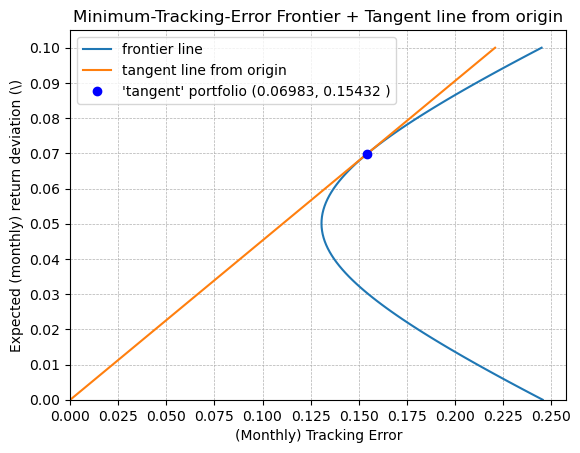

In [13]:
rf = 0
var_list_riskfree = []
for x in possible_rp:
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x, rf))

f3, ax3 = plt.subplots(1)
# f3.set_figheight(7)
# f3.set_figwidth(10)
ax3.plot(np.sqrt(var_list), possible_rp, label="frontier line")
# ax3.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
#         label = f"global minimum variance portfolio ({np.sqrt(newmva.var_mva(newmva.R_mv)):.5f}, {newmva.R_mv:.5f} )")
ax3.plot(np.sqrt(var_list_riskfree), possible_rp, label="tangent line from origin")
ax3.plot(
    tangent_portfolio["std_dev"],
    tangent_portfolio["return"],
    "bo",
    label=f"'tangent' portfolio ({tangent_portfolio['return']:.5f}, {tangent_portfolio['std_dev']:.5f} )",
)
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.set_xlabel("(Monthly) Tracking Error")
ax3.set_ylabel("Expected (monthly) return deviation (\)")
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.025))
ax3.set_title("Minimum-Tracking-Error Frontier + Tangent line from origin")
# ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax3.grid(linestyle="--", linewidth=0.5)
ax3.legend()
plt.show(f3)
f3.savefig("f3.jpg")

In [14]:
tangent_portfolio = newmva.tangent_portfolio(possible_rp, 0)
tangent_portfolio["tangent_weights"]

array([5.26341943e-02, 1.53428449e-04, 1.37626709e-01, 8.70322403e-02,
       1.79352886e-01, 7.10739711e-02, 1.06884468e-01, 1.02775950e-01,
       4.01622131e-02, 2.22303939e-01])

## part 2 of the assignment ! ##

In [15]:
portfolio = concated_df[portfolio_cols]
portfolio_mean = portfolio.mean()
portfolio_std = portfolio.std()
portfolio_cov = portfolio.cov()

In [16]:
i = 0
mean_arr = []
stdev_arr = []
mean_inv_arr = []
stdev_inv_arr = []

# ishoudl vectorize this
while i < 10e5:
    # generate rand
    rand_weight = np.random.uniform(0, 1, 10)
    inv_rand_weight = np.reciprocal(rand_weight)

    # normalize with sum
    rand_weight = rand_weight / np.sum(rand_weight)
    inv_rand_weight = inv_rand_weight / np.sum(inv_rand_weight)

    # mutliply random weights with port mean (not portfolio excess !)
    rand_port = rand_weight * portfolio_mean
    inv_rand_port = inv_rand_weight * portfolio_mean

    # append mean points
    mean_arr.append(rand_port.sum())
    mean_inv_arr.append(inv_rand_port.sum())

    # append var points
    stdev_arr.append(np.sqrt(np.dot(np.dot(rand_weight.T, portfolio_cov), rand_weight)))
    stdev_inv_arr.append(
        np.sqrt(np.dot(np.dot(inv_rand_weight.T, portfolio_cov), inv_rand_weight))
    )

    i += 1

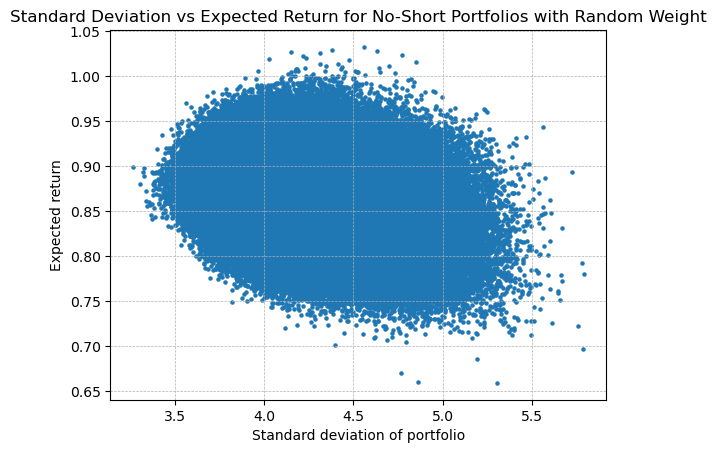

In [17]:
f4, ax4 = plt.subplots(1)
# f4.set_figheight(7)
# f4.set_figwidth(10)
ax4.scatter(stdev_arr, mean_arr, s=5)
ax4.set_xlabel("Standard deviation of portfolio")
ax4.set_ylabel("Expected return")
ax4.set_title(
    "Standard Deviation vs Expected Return for No-Short Portfolios with Random Weight"
)
# ax4.xaxis.set_major_locator(plt.MultipleLocator(0.025))
# ax4.set_xlim(xmin=0)
ax4.grid(linestyle="--", linewidth=0.5)
f4.savefig("f4.jpg")

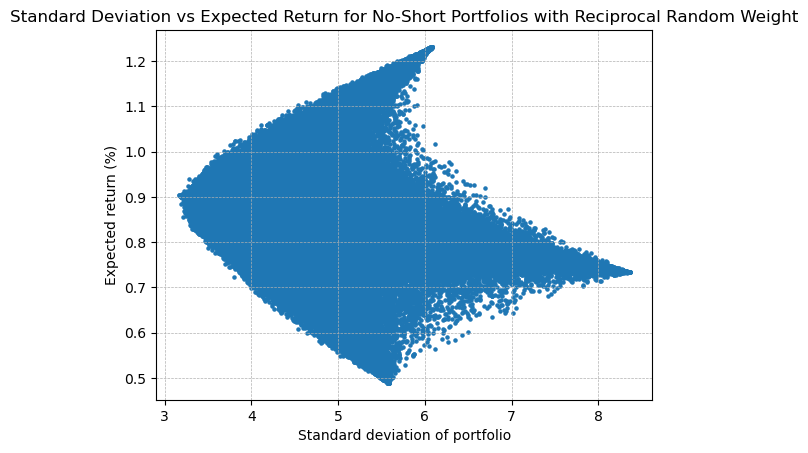

In [18]:
f5, ax5 = plt.subplots(1)
# f5.set_figheight(7)
# f5.set_figwidth(10)
ax5.scatter(stdev_inv_arr, mean_inv_arr, s=5)
ax5.set_xlabel("Standard deviation of portfolio")
ax5.set_ylabel("Expected return (%)")
ax5.set_title(
    "Standard Deviation vs Expected Return for No-Short Portfolios with Reciprocal Random Weight"
)
# ax5.xaxis.set_major_locator(plt.MultipleLocator(0.025))
# ax5.set_xlim(xmin=0)
ax5.grid(linestyle="--", linewidth=0.5)
f5.savefig("f5.jpg")